# k-means Clustering

This example notebook applies *k*-means clustering to the CHI data from the [HCI Bibliography](http://hcibib.org)

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

## Load Data

In [3]:
papers = pd.read_csv('data/chi-papers.csv', encoding='utf8')
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13403 entries, 0 to 13402
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13292 non-null  object 
 1   year      13370 non-null  float64
 2   title     13370 non-null  object 
 3   keywords  3504 non-null   object 
 4   abstract  12872 non-null  object 
dtypes: float64(1), object(4)
memory usage: 523.7+ KB


Let's treat empty abstracts as empty strings:

In [4]:
papers['abstract'].fillna('', inplace=True)
papers['title'].fillna('', inplace=True)

For some purposes, we want *all text*.  Let's make a field:

In [5]:
papers['all_text'] = papers['title'] + ' ' + papers['abstract']

## Raw Clustering

Let's set up a *k*-means to make 10 clusters out of our titles and abstracts.  We're going to also limit the term vectors to only the 10K most common words, to make the vectors more manageable.

In [6]:
cluster_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('cluster', KMeans(10))
])

In [7]:
cluster_pipe.fit(papers['all_text'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('cluster', KMeans(n_clusters=10))])

Now, if we want clusters for all of our papers, we use `predict`:

In [8]:
paper_clusters = cluster_pipe.predict(papers['all_text'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

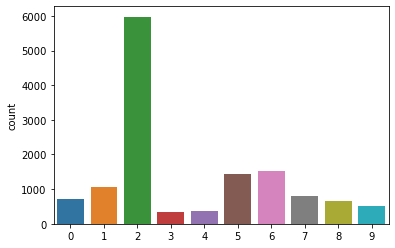

In [9]:
sns.countplot(paper_clusters)

We can, for instance, get the titles of papers in cluster 0:

In [10]:
papers.loc[paper_clusters == 0, 'title']

58          The Social Life of Small Graphical Chat Spaces
59       The Effect of Communication Modality on Cooper...
200             Interacting with music in a social setting
230      Visualization Components for Persistent Conver...
254      Casablanca: Designing Social Communication Dev...
                               ...                        
13216    Trust me, I'm accountable: trust and accountab...
13220                  Counting on community in cyberspace
13221              Social navigation: what is it good for?
13266    Emotional Interfaces for Interactive Aardvarks...
13396       SIGCHI's role in influencing technology policy
Name: title, Length: 723, dtype: object

This created a Boolean mask that is `True` where the cluster number is equal to 0, and selects those rows and the `'title'` column.

Don't know if these papers make any sense, but they are clusters.  We aren't doing anything to find the *most* central papers to the cluster, though.

We can get that with `transform`, which will transform papers into *cluster distance space* - columns are the distances between each paper and that cluster:

In [11]:
paper_cdist = cluster_pipe.transform(papers['all_text'])

And we can find the papers *closest to the center* of cluster 0:

In [12]:
closest = np.argsort(paper_cdist[:, 0])[-10:]
papers.iloc[closest]['title']

5426                       Olympic voting system proposal
5111    Molehill: An Instructional System for Smalltal...
5404                                    eLearning and fun
3082         Anthropomorphism: From Eliza to Terminator 2
2781                             UIMSs: Threat or Menace?
5428                                            Shake it!
5374                                        Kick-up menus
2478    Indentation, Documentation and Programmer Comp...
3130                        Toward a More Humane Keyboard
5427                    PHOTOVOTE: Olympic judging system
Name: title, dtype: object

We can also look at clusters in space.  *t*-SNE is a technique for dimensionality reduction that is emphasized on visualizability.  Let's compute the *t*-SNE of our papers:

In [13]:
sne_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('sne', TSNE())
])
paper_sne = sne_pipe.fit_transform(papers['all_text'])
paper_sne

array([[-0.3343415 ,  0.10081321],
       [-3.7924821 ,  0.9259159 ],
       [-0.3632512 , -1.0941954 ],
       ...,
       [ 3.5736983 ,  1.3643941 ],
       [ 1.9688647 ,  4.274018  ],
       [ 0.09175982,  0.5219902 ]], dtype=float32)

Now we can plot:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SNE0', ylabel='SNE1'>

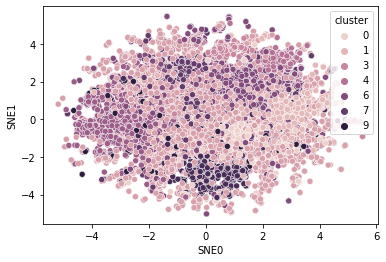

In [14]:
paper_viz = pd.DataFrame({
    'SNE0': paper_sne[:, 0],
    'SNE1': paper_sne[:, 1],
    'cluster': paper_clusters
})
sns.scatterplot('SNE0', 'SNE1', hue='cluster', data=paper_viz)

## SVD-based Clusters

Let's cluster in reduced-dimensional space:

In [15]:
svd_cluster_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(25)),
    ('cluster', KMeans(10))
])
paper_svd_clusters = svd_cluster_pipe.fit_predict(papers['all_text'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

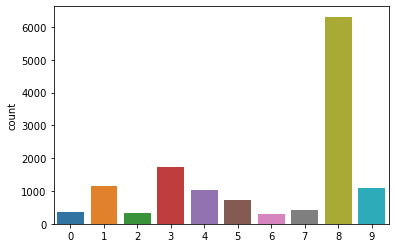

In [16]:
sns.countplot(paper_svd_clusters)

In [17]:
paper_svd_cdist = svd_cluster_pipe.transform(papers['all_text'])

Let's look at Cluster 0 in this space:

In [18]:
closest = np.argsort(paper_svd_cdist[:, 0])[-10:]
papers.iloc[closest]['title']

7979     What is the next generation of human-computer ...
2508                Designing the Human-Computer Interface
6114     Enhancing credibility judgment of web search r...
3855     A large scale study of wireless search behavio...
12018                            Visual Interaction Design
2770     Video: Data for Studying Human-Computer Intera...
10302    An In-Situ Study of Mobile App &amp; Mobile Se...
2860                               Search Technology, Inc.
12010                               The Design Interaction
3724                         Social interaction in 'there'
Name: title, dtype: object

Not sure if that's better, but it shows the concept.

Let's do the color-coded SNE visualization:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SNE0', ylabel='SNE1'>

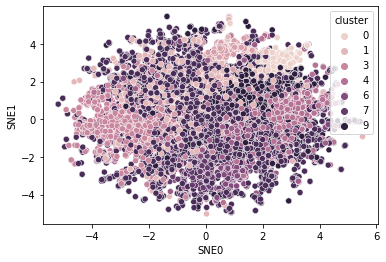

In [19]:
paper_viz = pd.DataFrame({
    'SNE0': paper_sne[:, 0],
    'SNE1': paper_sne[:, 1],
    'cluster': paper_svd_clusters
})
sns.scatterplot('SNE0', 'SNE1', hue='cluster', data=paper_viz)